<a href="https://colab.research.google.com/github/justpablo/tmsql_ml_project3_deep_learning/blob/main/UseCase_PimaCounty_pabloreynoso.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Enhance IT**
## **Project 3**: *Pima County Use Case: Feature Enigneering, Grouping Observations, Forecasting: Selling Price, Location Recommender: Hospitals, Stores, Schools, Churches*
## **Data**: *Tucson, Az (Pima County) Houses for Sale*
## **Profesor**: *Jaime Ruiz*
## **Group**: *The Matrix SQL*
## **Student**: *Pablo Reynoso*
## **Date**: *December 27th, 2021*



### Pima County (Tucson, Az ) Houses for Sale

The observations from *Tucson, Az (Pima County) Houses for Sale* dataset describe a potential correlation between house's attributes and a attribute of interes, in particular *Sold Price* for a specific population, *Pima County* [1].

Pima County Population Specifications:

*   Population: 1,043,433

*   Age Distribution: Centered on 18-65 (53.7%)

*   Median Gross Rent: $907 USD

*   Adults 25+ w/ Bachelor+ Diploma: 32.4%

*   Meadian Wages Yearly: $53,379 USD

*   Meadian Wages Yearly (per capita): $29,707 USD

[1]https://www.census.gov/quickfacts/fact/table/pimacountyarizona/HSG445219#HSG445219

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sn; sn.set()
import matplotlib.cm as cm 


from scipy.stats import multivariate_normal as mvn


data = pd.read_csv('/content/drive/MyDrive/Classroom/Matrix_SQL/project1_eda/Pablo Reynoso - raw_house_data.csv')

## 1) Data Exploration

In [3]:
# I) Describing House Attributes
# a) Houses Data Dimensions
print("Dimensions: "+str(data.shape))

# b) Houses Attributes Names
print("\nFeatures Type: \n")
print(data.dtypes)

Dimensions: (5000, 16)

Features Type: 

MLS                   int64
sold_price          float64
zipcode               int64
longitude           float64
latitude            float64
lot_acres           float64
taxes               float64
year_built            int64
bedrooms              int64
bathrooms            object
sqrt_ft              object
garage               object
kitchen_features     object
fireplaces           object
floor_covering       object
HOA                  object
dtype: object


In [4]:
# II) Visual Inspection First/Last Observations
print("\nFirst Observations:")
print(data.head())


First Observations:
        MLS  sold_price  zipcode  ...  fireplaces                floor_covering   HOA
0  21530491   5300000.0    85637  ...           6            Mexican Tile, Wood     0
1  21529082   4200000.0    85646  ...           5          Natural Stone, Other     0
2   3054672   4200000.0    85646  ...           5    Natural Stone, Other: Rock  None
3  21919321   4500000.0    85646  ...           4  Ceramic Tile, Laminate, Wood  None
4  21306357   3411450.0    85750  ...           5              Carpet, Concrete    55

[5 rows x 16 columns]


## 2) Data Cleaning (Missing Values in Columns, Duplicated Rows)

In [5]:
#III) Imputation of Missing Data 

# IMPUTATION NOTES: 
#   Mean & interpolation are considered based on the following assumptions:
#     Assumption 1. Missing Data Completely Random
#     Assumption 2. Missing Data Look Like The Majority or Approximate
#     Assumption 3. Loss of Correlation Between Rest of Attributes

# HIGHLIGHTS: 
#   --- The only attribute (numeric, in priniciple) with missing values (np.Nan, pd.Nat, null, None) is 'lot_acres'
#   --- Attribute distribution is skewed to the left, so we impute with MEDIAN instead MEAN to avoid bias (outliers)
#       The percentage of missing values in lot_acres is 0.2% (10/5000) < 5.0% of obs MINIMUM impact
#   --- Linear Interpolation Preserves the Statistics of the Attribue


# a) Numeric Attrbutes Imputations
#     -zipcode # NOTE: convert to str variable
#data['zipcode'] = data['zipcode'].astype('category')

#     -lot_acres # NOTE: 0.0/Np.Nan is missing value for lot_acres, interpolate
data['lot_acres'] = np.where(data['lot_acres'] == 0.0, np.nan, data['lot_acres'])
data['lot_acres'] = data['lot_acres'].interpolate(method ='linear', limit_direction ='forward')

#     -taxes #NOTE: 0.0 is missing value for taxes, interpolate
data['taxes'] = np.where(data['taxes'] == 0.0, np.nan, data['taxes'])
data['taxes'] = data['taxes'].interpolate(method ='linear', limit_direction ='forward')

#     -year_built #NOTE: 0 is missing value for year_built, impute mode
data['year_built'] = np.where(data['year_built'] == 0, data['year_built'].mode(), data['year_built'])
#data['year_built'] = data['year_built'].astype('category')

# b) Categorical Attributes Imputations
#     -bathrooms #NOTE: 'None' is mistaken value (turn to 0), convert float
data['bathrooms'] = np.where(data['bathrooms'] == 'None', '0.0', data['bathrooms'])
data['bathrooms'] = data['bathrooms'].astype('float64')

#     -sqrt_ft #NOTE: 'None' is a missing value interpolate, convert float
data['sqrt_ft'] = np.where(data['sqrt_ft'] == 'None', np.nan, data['sqrt_ft'])
data['sqrt_ft'] = data['sqrt_ft'].astype('float64')
data['sqrt_ft'] = data['sqrt_ft'].interpolate(method ='linear', limit_direction ='forward')

#     -garage #NOTE: 'None' is mistaken value (turn to 0), convert float
data['garage'] = np.where(data['garage'] == 'None', '0.0', data['garage'])
data['garage'] = data['garage'].astype('float64')

#     -kitchen_features #NOTE: 'None' == 'Missing:Kitchen' == 'Missing: All Appliances', normalize strings, convert in string type
data['kitchen_features'] = np.where(data['kitchen_features'] == 'None', 'Missing:Kitchen', data['kitchen_features'])
data['kitchen_features'] = np.where(data['kitchen_features'] == 'Missing: All Appliances', 'Missing:Kitchen', data['kitchen_features'])
data['kitchen_features'] = data['kitchen_features'].astype('string')

#     -fireplaces #NOTE:' ' is mistaken value (turn to 0)
data['fireplaces'] = np.where(data['fireplaces'] == ' ', '0', data['fireplaces'])
data['fireplaces'] = data['fireplaces'].astype('int64')

#     -floor_covering #NOTE: 'Other: None' == 'None', normalize to 'Other: None', convert string type
data['floor_covering'] = data['floor_covering'].astype('string')

#     -HOA #NOTE 'None' is Missing Value, interpolate, Convert to float
data['HOA'] = data['HOA'].str.extract('(\d+)', expand=False)
data['HOA'] = np.where(data['HOA'] == 'None', np.nan, data['HOA'])
data['HOA'] = data['HOA'].astype('float64')
data['HOA'] = data['HOA'].interpolate(method ='linear', limit_direction ='forward')

In [6]:
# IV) Remove Duplicates of Observations if Any (None)
data.drop_duplicates(keep="first",inplace=True)

## 3) Data Distribution (Latitude, Longitude) & Counties Outliers Removal

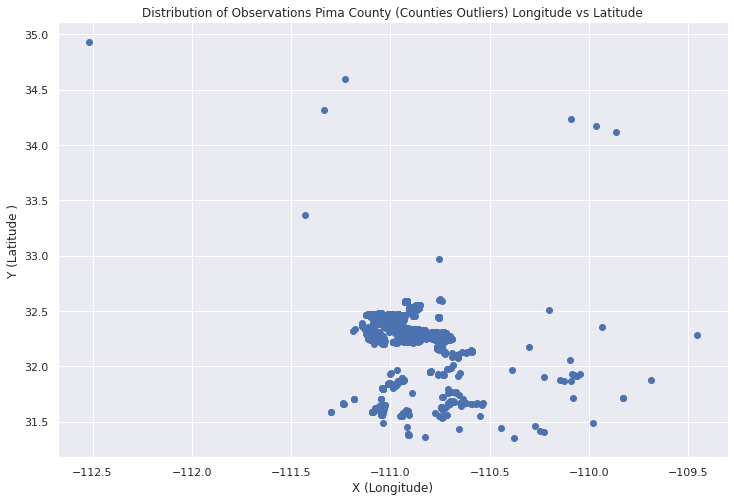

In [7]:
# V) Distribution of the Observations 
plt.figure(figsize=(12,8))
plt.xlabel('X (Longitude)')
plt.ylabel('Y (Latitude )')
plt.scatter(data['longitude'], data['latitude'])
plt.title("Distribution of Observations Pima County (Counties Outliers) Longitude vs Latitude")
plt.savefig('figure1_original_scatter_obs_lat_vs_long.png')

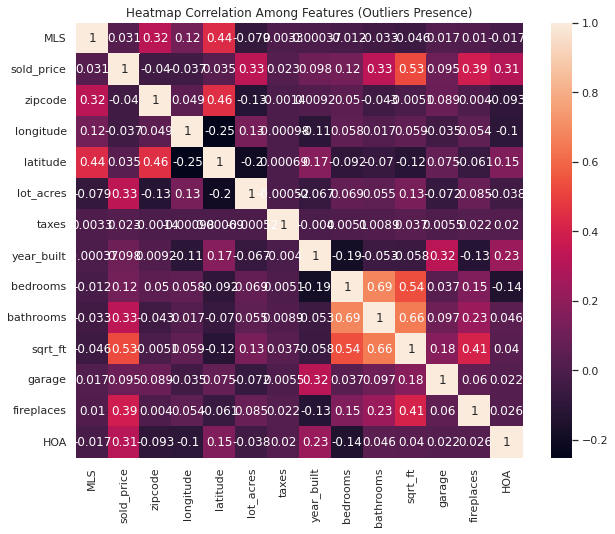

In [8]:
# Initial Correlation among Features

correlation = data.corr()
plt.figure(figsize=(10,8))
sn.heatmap(correlation, xticklabels=correlation.columns, yticklabels=correlation.columns, annot=True)
plt.title('Heatmap Correlation Among Features (Outliers Presence)')
plt.savefig('figure1_original_heatmap_correlations_features.png')

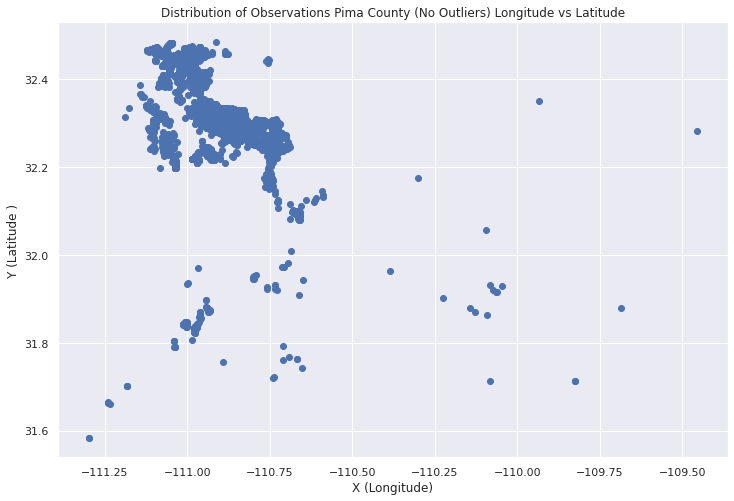

In [9]:
# VI) Dropping Outlier Observations Keeping Pima County

# Note A: Discarding House/Living Units: Maricopa/Pinal Counties (Outliers) 
data.drop(data[data['latitude'] > 32.50].index, inplace = True)
# Note B: Discarding House/Living Units: Some Yuma/Cochise (Outliers)
data.drop(data[(data['longitude'] > -110.46) & (data['longitude'] < -113.33) ].index, inplace = True)
# Note C: Discarding House/Living Units: Some Santa Cruz/Cochise (Outliers)
data.drop(data[(data['latitude'] < 31.71) & (data['longitude'] > -111.16)].index, inplace = True)

# Distribution of the Observations (No Outliers)
plt.figure(figsize=(12,8))
plt.xlabel('X (Longitude)')
plt.ylabel('Y (Latitude )')
plt.scatter(data['longitude'], data['latitude'])
plt.title("Distribution of Observations Pima County (No Outliers) Longitude vs Latitude")
plt.savefig('figure2_no_outliers_scatter_obs_lat_vs_long.png')

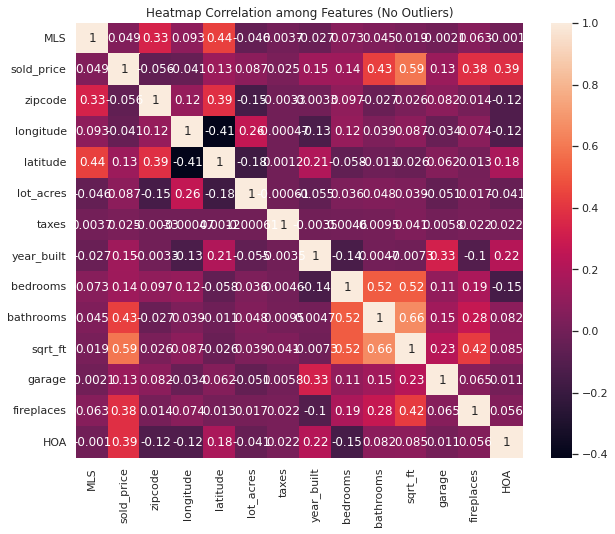

In [10]:
# Correlation among Features (No Outliers)

correlation = data.corr()
plt.figure(figsize=(10,8))
sn.heatmap(correlation, xticklabels=correlation.columns, yticklabels=correlation.columns, annot=True)
plt.title('Heatmap Correlation among Features (No Outliers)')
plt.savefig('figure2_original_heatmap_correlations_features_no_outliers.png')

In [11]:
# Pima County Houses Data Dimensions (No Outliers)
print("Dimensions: "+str(data.shape))

Dimensions: (4695, 16)


## 4) Feature Selection by Correlation Matrix

In [12]:
# VII) Feature Engineering Feature Based on Number of Floor Materials Used in the Housing Unit
data['floor_num_materials'] = data.apply(lambda row: len(row.floor_covering.split(', ')), axis=1)
print("Dimensions: "+str(data.shape))


Dimensions: (4695, 17)


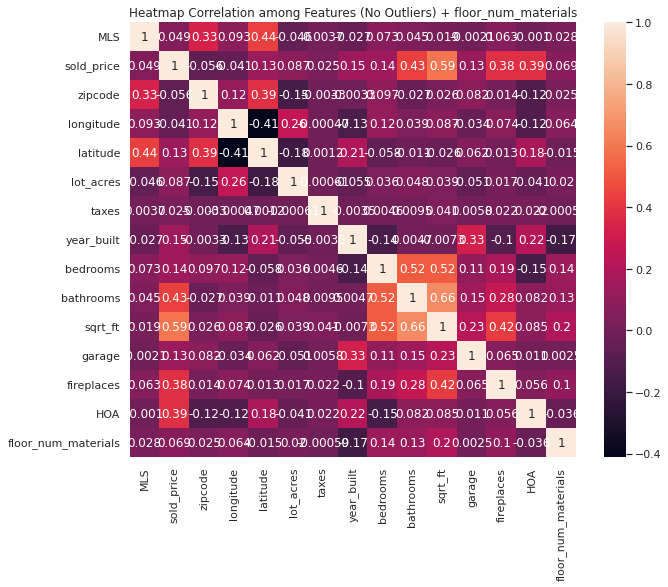

In [13]:
# Correlation among Features (No Outliers) + floor_materials number of materials per unit
correlation = data.corr()
plt.figure(figsize=(10,8))
sn.heatmap(correlation, xticklabels=correlation.columns, yticklabels=correlation.columns, annot=True)
plt.title('Heatmap Correlation among Features (No Outliers) + floor_num_materials')
plt.savefig('figure3_original_heatmap_correlations_features_no_outliers_floor_num_materials.png')

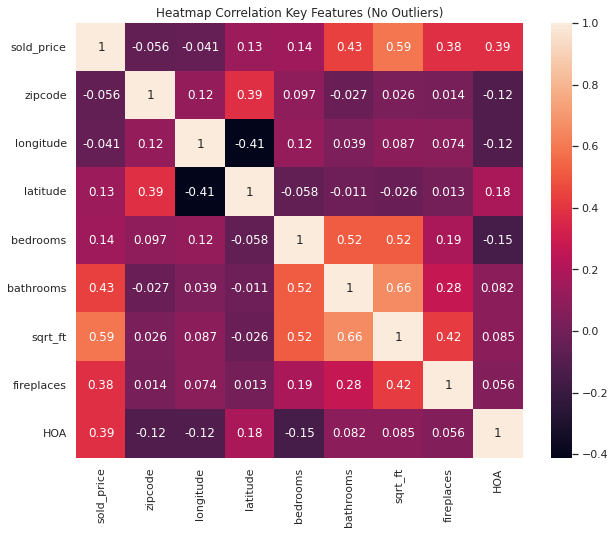

In [14]:
# VIII) Dropping Variables Not Related to latitude, longitude, sold_price
data = data.drop(['taxes', 'MLS', 'lot_acres','garage','floor_num_materials','year_built','kitchen_features'], axis=1)

# Correlation on Relevant Features with Respect to sold_price, latitude, longitude
correlation = data.corr()
plt.figure(figsize=(10,8))
sn.heatmap(correlation, xticklabels=correlation.columns, yticklabels=correlation.columns, annot=True)
plt.title('Heatmap Correlation Key Features (No Outliers)')
plt.savefig('figure3_original_heatmap_correlations_key_features_no_outliers.png')

## 5) Finding Outliers in ALL Features Boxplot

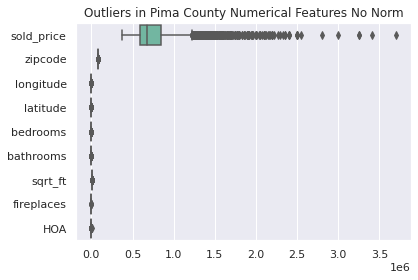

In [15]:
ax = sn.boxplot(data=data, orient="h", palette="Set2")
plt.title('Outliers in Pima County Numerical Features No Norm')
plt.savefig('figure4_whisker_boxplot_outliers_features_no_norm.png')

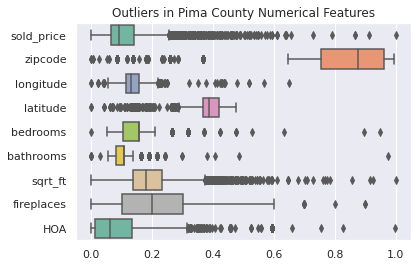

In [16]:
# IX) Normalizing Data to Find Outliers
data_ = data.copy(deep=True)
cols = ['sold_price', 'longitude', 'latitude', 'zipcode', 'bedrooms', 'bathrooms', 'sqrt_ft', 'fireplaces', 'HOA']

for c in cols:
  data_[c] = 1.0 * (data_[c] - data_[c].min()) / (1+data_[c].max() - data_[c].min())

ax = sn.boxplot(data=data_, orient="h", palette="Set2")
plt.title('Outliers in Pima County Numerical Features')
plt.savefig('figure4_whisker_boxplot_outliers_features.png')

## 6) Encoding floor_covering (string) Feature to One-Hot-Encoding
 


In [17]:
# VIII) Feature Normalization: Normalizing floor_covering values
# NOTe: Floor Covering range of string values ?

# A) Lower Casing Strings
data['floor_covering'] = data['floor_covering'].str.lower() 
# B) Remove White Spaces Beg-End
data['floor_covering'] = data['floor_covering'].str.strip()
# C) Remove Specials
data['floor_covering'] = data['floor_covering'].str.replace('other: ', '')
data['floor_covering'] = data['floor_covering'].str.replace(' x ', 'x')
# D) Correcting Typos/Plurals
typos = dict({'porclain':'porcelain', 'porcelyn':'porcelain','egytian':'egyptian', 'polishd':'polished', 'aggrgt':'aggregated', 'wood plan laminate': 'wood laminate',
              'polish concrete': 'polished concrete', 'lime stone':'limestone', 'tile-other':'tile', 'see remarks':'other'})
plurals = dict({'pavers':'paver', 'planks':'plank', 'accents':'accent', 'bathrooms':'bathroom', 'bedrooms':'bedroom',
                'types':'type', 'floors':'floor'})
alphanums = ['/','&','-','%']

for k,v in typos.items():
  data['floor_covering'] = data['floor_covering'].str.replace(k,v)
for k,v in plurals.items():
  data['floor_covering'] = data['floor_covering'].str.replace(k,v)
for alp in alphanums:
  data['floor_covering'] = data['floor_covering'].str.replace(alp,'_')

# E) Underscore Str Value Convention
for l in data['floor_covering'].index.tolist():
  floor_ = ", ".join([a.replace(' ','_') for a in data.loc[l, 'floor_covering'].split(', ')])
  data.loc[l, 'floor_covering'] = floor_

# F) Correcting Extra
data['floor_covering'] = data['floor_covering'].str.replace('travertine___slate', 'travertine_slate')
data['floor_covering'] = data['floor_covering'].str.replace('master_bedroom__tile', 'master_bedroom_tile')
data['floor_covering'] = data['floor_covering'].str.replace('carpet__guest_house', 'carpet_guest_house')
data['floor_covering'] = data['floor_covering'].str.replace('100__porcelain_tile', '100_porcelain_tile')
data['floor_covering'] = data['floor_covering'].str.replace('eng_wood', 'engineered_wood')
data['floor_covering'] = data['floor_covering'].str.replace('lux_vinyl', 'luxury_vinyl')

# G) Grouping floor_covering sub_values to (porcelain, concrete, brick, tile) 
materials = ['porcelain','concrete','travertine','wood','brick','carpet','vinyl','laminate','saltillo','marble','tile']
for mt in materials:
  for l in data['floor_covering'].index.tolist():
    floor_ = ", ".join([mt if a.find(mt)!=-1 else a for a in data.loc[l, 'floor_covering'].split(', ')])
    data.loc[l, 'floor_covering'] = floor_

In [18]:
# Display floor_covering (Normalized, Summarized) Values
floor_coverings = data['floor_covering'].str.split(', ').tolist()
flat_floor_coverings = [item for sublists in floor_coverings for item in sublists]
unique_floor_coverings = list(set(flat_floor_coverings))
for uq in unique_floor_coverings:
  print(uq)
print(len(unique_floor_coverings))

# Temporal Copy of Data
data_tmp = data.copy(deep=True)

slate
none
carpet
saltillo
natural_stone
concrete
20x20_on_diagonal
indoor_outdoor
laminate
terrazzo
tbd
canterra_stone
flagstone
upg_flooring
other
bamboo
cork
throughout_home
quartzite
granite
tile
marble
brazilian_pergo
egyptian_sandstone
porcelain
multiple_type
travertine
parquet
talavera_floor
real_polished_aggregated
pergo
limestone
acrylic_overlay
vinyl
brick
wood
36


In [19]:
# Feature Enigneering: floor_covering representation to One-Hot-Encoding

# H) floor_covering Bag of Words
floor_coverings = data['floor_covering'].str.split(', ').tolist()
flat_floor_coverings = [item for sublists in floor_coverings for item in sublists]
unique_floor_coverings = list(set(flat_floor_coverings))
if 'none' in unique_floor_coverings:
  unique_floor_coverings.remove('none')
print(unique_floor_coverings)

# I) One Hot Encoding of Multi String Feature to Vector of Ocurrences
data = data.reindex(data.columns.tolist() + unique_floor_coverings, axis=1, fill_value=0)
for index, row in data.iterrows():
    for val in row.floor_covering.split(', '):
        if val != 'none':
            data.loc[index, val] = 1
data.drop(columns=['floor_covering'], axis = 1, inplace = True)


['slate', 'carpet', 'saltillo', 'natural_stone', 'concrete', '20x20_on_diagonal', 'indoor_outdoor', 'laminate', 'terrazzo', 'tbd', 'canterra_stone', 'flagstone', 'upg_flooring', 'other', 'bamboo', 'cork', 'throughout_home', 'quartzite', 'granite', 'tile', 'marble', 'brazilian_pergo', 'egyptian_sandstone', 'porcelain', 'multiple_type', 'travertine', 'parquet', 'talavera_floor', 'real_polished_aggregated', 'pergo', 'limestone', 'acrylic_overlay', 'vinyl', 'brick', 'wood']


## 7) Grouping Data by sold_price/sqrt_ft feature & Split Train/Test Sets


In [20]:
# Finding Categories for Observations based on sold_price/sqrt_ft
data['sold_price_sqft_ratio'] = data.apply(lambda row: row.sold_price/row.sqrt_ft, axis=1)

# Shuffle ALL Data random_state=9
data = data.sample(frac=1.0, random_state=9)
data.reset_index(drop=True, inplace=True)

# Split Data into X for Train/Test
# Train: 85% Data; Test: 15%
rows = data.shape[0]

X_train = data.loc[:rows*0.90,:]
X_test = data.loc[(rows*0.90):,:]

#Creating sold_price/sqrt_ft bins
min_ratio = X_train['sold_price_sqft_ratio'].min()
max_ratio = X_train['sold_price_sqft_ratio'].max()
price_sqft_bins = np.linspace(min_ratio, max_ratio, 9)
y_train = np.digitize(X_train['sold_price_sqft_ratio'], price_sqft_bins, right=False)


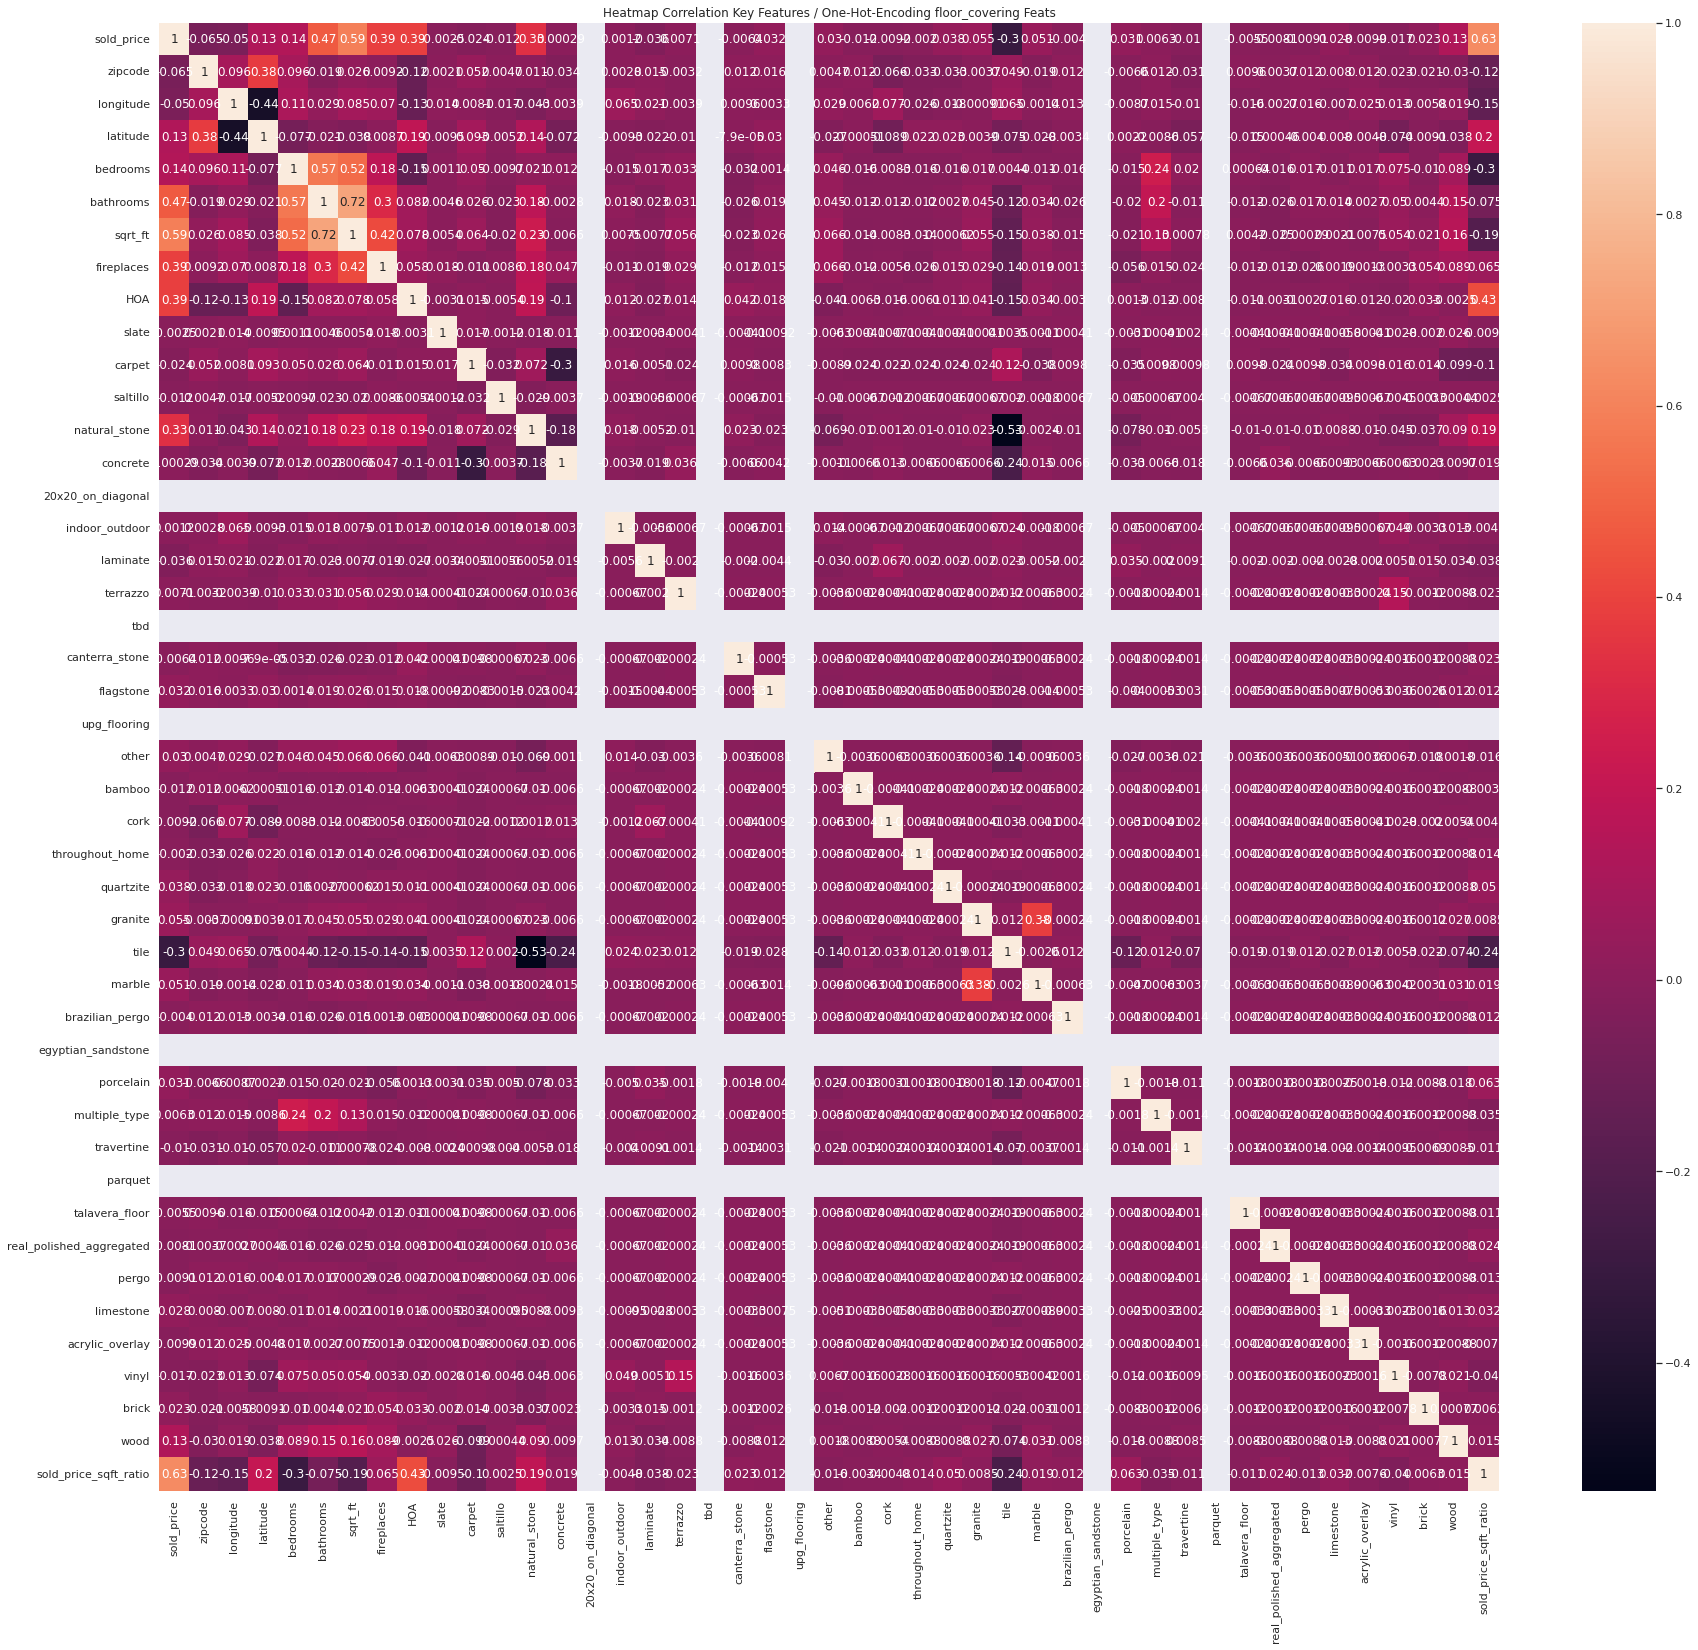

In [21]:
# Correlation on floor_covering One-Hot-Encoding features
correlation = X_train.corr()
plt.figure(figsize=(30,27))
sn.heatmap(correlation, xticklabels=correlation.columns, yticklabels=correlation.columns, annot=True)
plt.title('Heatmap Correlation Key Features / One-Hot-Encoding floor_covering Feats')
plt.savefig('figure5_original_heatmap_correlations_key_features_floor_covering_ohe.png')

In [22]:
# Drop Non-Correlated (sold_price, sold_price_sqft_ratio):
# Less Correlated Features (floor_covering):
non_corr_feats_to_price_sqft_cat = ['egyptian_sandstone', '20x20_on_diagonal',
                                    'upg_flooring','tbd','parquet','flagstone',
                                    'pergo', 'concrete', 'carpet', 'throughout_home',
                                    'saltillo', 'acrylic_overlay', 'brick', 'slate',
                                    'indoor_outdoor', 'quartzite', 'canterra_stone', 
                                    'porcelain', 'bamboo', 'limestone', 'talavera_floor',
                                    'real_polished_aggregated', 'terrazzo', 'cork',
                                    'brazilian_pergo','travertine', 'laminate', 'other',
                                    'granite', 'marble', 'vinyl', 'multiple_type']
X_train = X_train.drop(non_corr_feats_to_price_sqft_cat, axis=1)
X_test = X_test.drop(non_corr_feats_to_price_sqft_cat, axis=1)


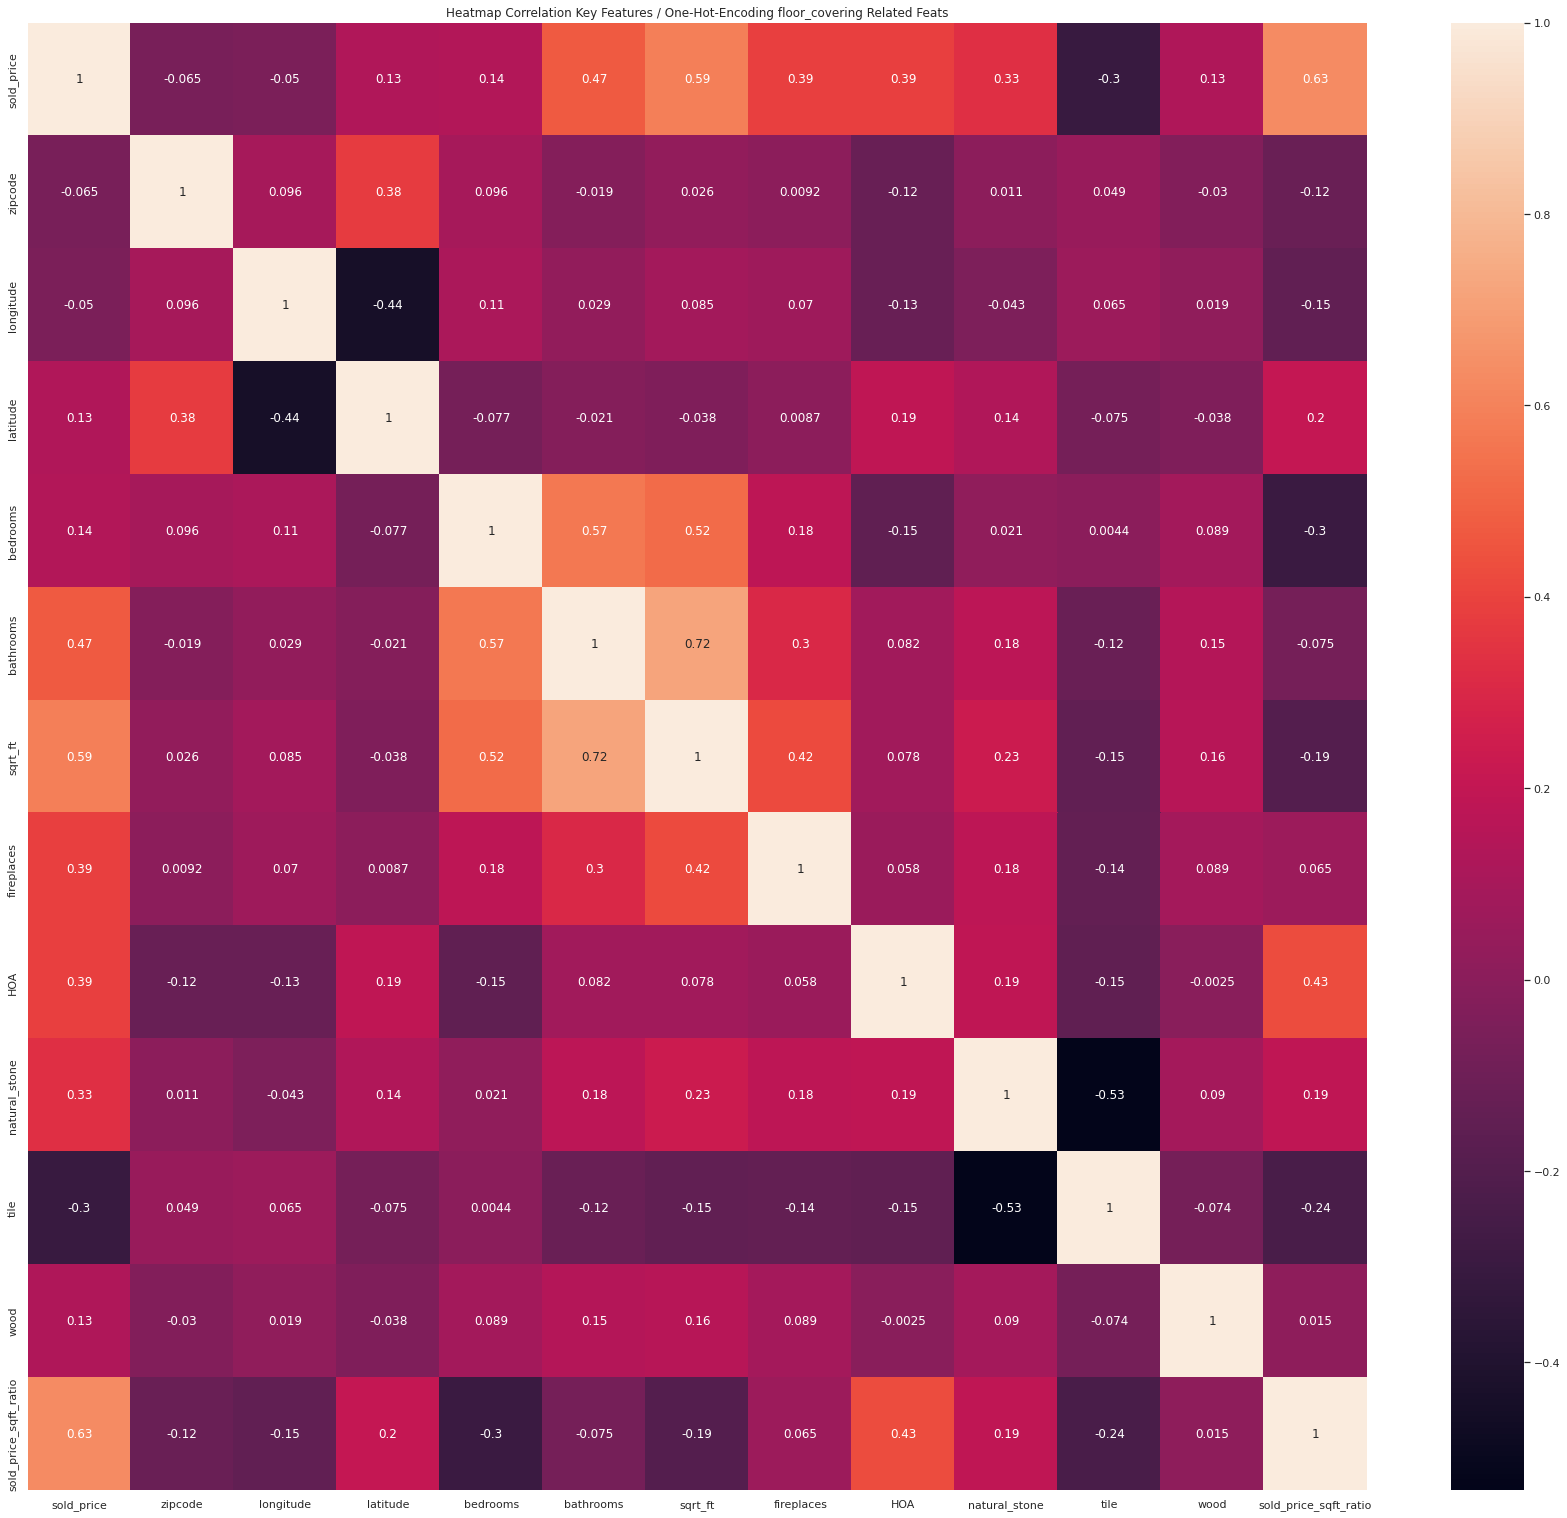

In [23]:
# Correlation on floor_covering One-Hot-Encoding features
correlation = X_train.corr()
plt.figure(figsize=(30,27))
sn.heatmap(correlation, xticklabels=correlation.columns, yticklabels=correlation.columns, annot=True)
plt.title('Heatmap Correlation Key Features / One-Hot-Encoding floor_covering Related Feats')
plt.savefig('figure5_original_heatmap_correlations_key_relatedfeatures_floor_covering_ohe.png')

## 8) Classification Models (GNB, KNN)


In [24]:
# NOTE: Supervised Learning Algorithm (Classification) -Bayes Theorem (Cov Matrix) (inputs as numpy.array)
class GaussBayes():
  def fit(self, X, y, epsilon = 1e-3):
    self.likelihoods = dict()
    self.priors = dict()
    self.K = set(y.astype(int))

    for k in self.K:
      X_k = X[y==k,:] 
      N_k, D = X_k.shape
      mu_k = X_k.mean(axis=0)

      self.priors[k] = len(X_k)/len(X)
      self.likelihoods[k] = {"mean": mu_k, "cov":(1/(N_k-1))*np.matmul((X_k-mu_k).T,X_k-mu_k)+epsilon*np.identity(D)}

  def predict(self, X):
    N, D = X.shape
    P_hat = np.zeros((N, len(self.K)))

    for k, l in self.likelihoods.items():
      P_hat[:,k] = mvn.logpdf(X,l["mean"],l['cov'])+np.log(self.priors[k])

    return P_hat.argmax(axis=1)

# NOTE: Lazy Learning Algorithm (Classification) -Similarities/Euclidean Distance (inputs as numpy.array)
class KNNClassifier():

  def fit(self, X, y):
    self.X=X
    self.y=y
    
  def predict(self, X, K, epsilon=1e-3):
    N = len(X)
    y_hat = np.zeros(N)

    for i in range(N):
      dist2 = np.sum((self.X-X[i])**2, axis=1)
      idxt = np.argsort(dist2)[:K]
      gamma_k = 1/(np.sqrt(dist2[idxt]+epsilon))
      y_hat[i] = np.bincount(self.y[idxt], weights=gamma_k).argmax()

    return y_hat

In [25]:
# KPI - Classification Key Performance Indicators
# Accuracy: ACC = Obs. Correct / Total Obs.
def accuracy(y, y_hat):
  return np.mean(y==y_hat)

# Confusion Matrix for Multi-Label Classification: (Max(Diagonal Sum), Balanced Performance for Every Label)
def confusion_matrix(y, y_hat):
  return pd.crosstab(y, y_hat)

## 9) Model Training & Classification of Test Set Observations (15%) in a sold_price/sqrt_ft category





In [26]:
print(X_train['sold_price'])
print(X_test['sold_price'])

print(y_train)

0        775000.0
1        800000.0
2        580000.0
3        575000.0
4        575000.0
          ...    
4221     645000.0
4222     602500.0
4223     745000.0
4224     780000.0
4225    1200000.0
Name: sold_price, Length: 4226, dtype: float64
4226     870000.0
4227     740000.0
4228     740000.0
4229     660000.0
4230     990000.0
          ...    
4690     815000.0
4691     805635.0
4692    1100000.0
4693     542000.0
4694    1260000.0
Name: sold_price, Length: 469, dtype: float64
[2 2 2 ... 2 2 2]


In [27]:
# KNN Training 
print(y_train.shape[0])

knn = KNNClassifier()
knn.fit(X_train.to_numpy(), y_train)
y_train_hat_knnc = knn.predict(X_train.to_numpy(),3)
print(y_train_hat_knnc.shape[0])

acc = accuracy(y_train,y_train_hat_knnc)
print("KNN Training Accuracy: acc="+str(acc))

4226
4226
KNN Training Accuracy: acc=1.0


In [28]:
y_test_hat_knnc = knn.predict(X_test.to_numpy(),3)

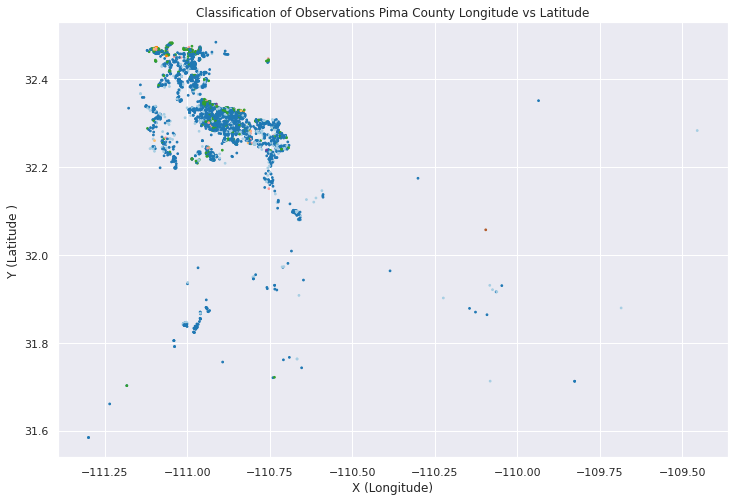

In [43]:
# Distribution of the Observations (No Outliers)

plt.figure(figsize=(12,8))
plt.xlabel('X (Longitude)')
plt.ylabel('Y (Latitude )')

plt.scatter(X_train['longitude'], X_train['latitude'], s=3, c=y_train_hat_knnc, cmap='Paired')
#plt.scatter(X_train['longitude'], X_train['latitude'], c=colormap[y_train_hat_knnc], alpha=0.7, s=100)
plt.title("Classification of Observations Pima County Longitude vs Latitude")
plt.savefig('figure5_classification_scatter_obs_lat_vs_long.png')

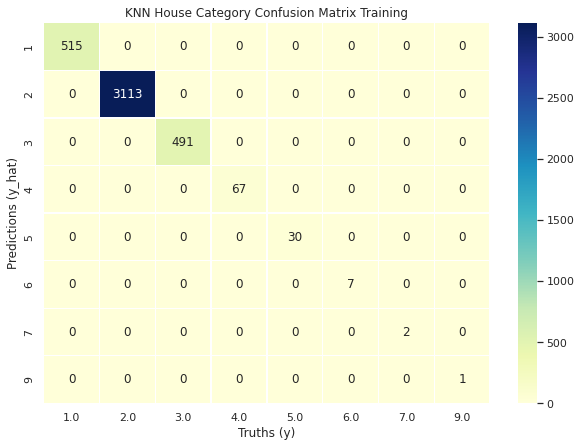

In [30]:
# Confusion Matrix
cm = confusion_matrix(y_train,y_train_hat_knnc)
plt.figure(figsize = (10,7))
plt.title("KNN House Category Confusion Matrix Training")
s = sn.heatmap(cm, fmt="d", linewidths=.3, annot=True, cmap="YlGnBu")
s.set(xlabel='Truths (y)', ylabel='Predictions (y_hat)')
plt.savefig('figure2_y_vs_y_hat_category_cm_knn.png') 
plt.show()

In [31]:
"""# GaussBayes Training --Error Singular Matrix (Determinant 0 in MVN)
gbm = GaussBayes()
gbm.fit(X_train.to_numpy(), y_train)
y_train_hat_gnbc = gbm.predict(X_train.to_numpy())
acc = accuracy(y_train,y_train_hat_gnbc)
print("GaussBayes Training Accuracy: acc="+str(acc))"""


'# GaussBayes Training --Error Singular Matrix (Determinant 0 in MVN)\ngbm = GaussBayes()\ngbm.fit(X_train.to_numpy(), y_train)\ny_train_hat_gnbc = gbm.predict(X_train.to_numpy())\nacc = accuracy(y_train,y_train_hat_gnbc)\nprint("GaussBayes Training Accuracy: acc="+str(acc))'

## 10) Use sold_price/sqrt_ft Category as Variable for Regression Models





In [32]:
X_train_ = X_train.copy(deep=True) 
X_test_ = X_test.copy(deep=True) 

In [33]:
X_train = pd.concat([X_train, pd.DataFrame(y_train, columns=['sold_price_sqft_cat'])], axis=1)
X_test = X_test.copy(deep=True)
X_test['sold_price_sqft_cat'] = np.zeros(X_test.shape[0])
X_test['sold_price_sqft_cat'] = y_test_hat_knnc

In [34]:
print(X_train.shape)
print(np.argwhere(np.isnan(X_test['sold_price_sqft_cat'].to_numpy())))
print(X_test.shape)


(4226, 14)
[]
(469, 14)


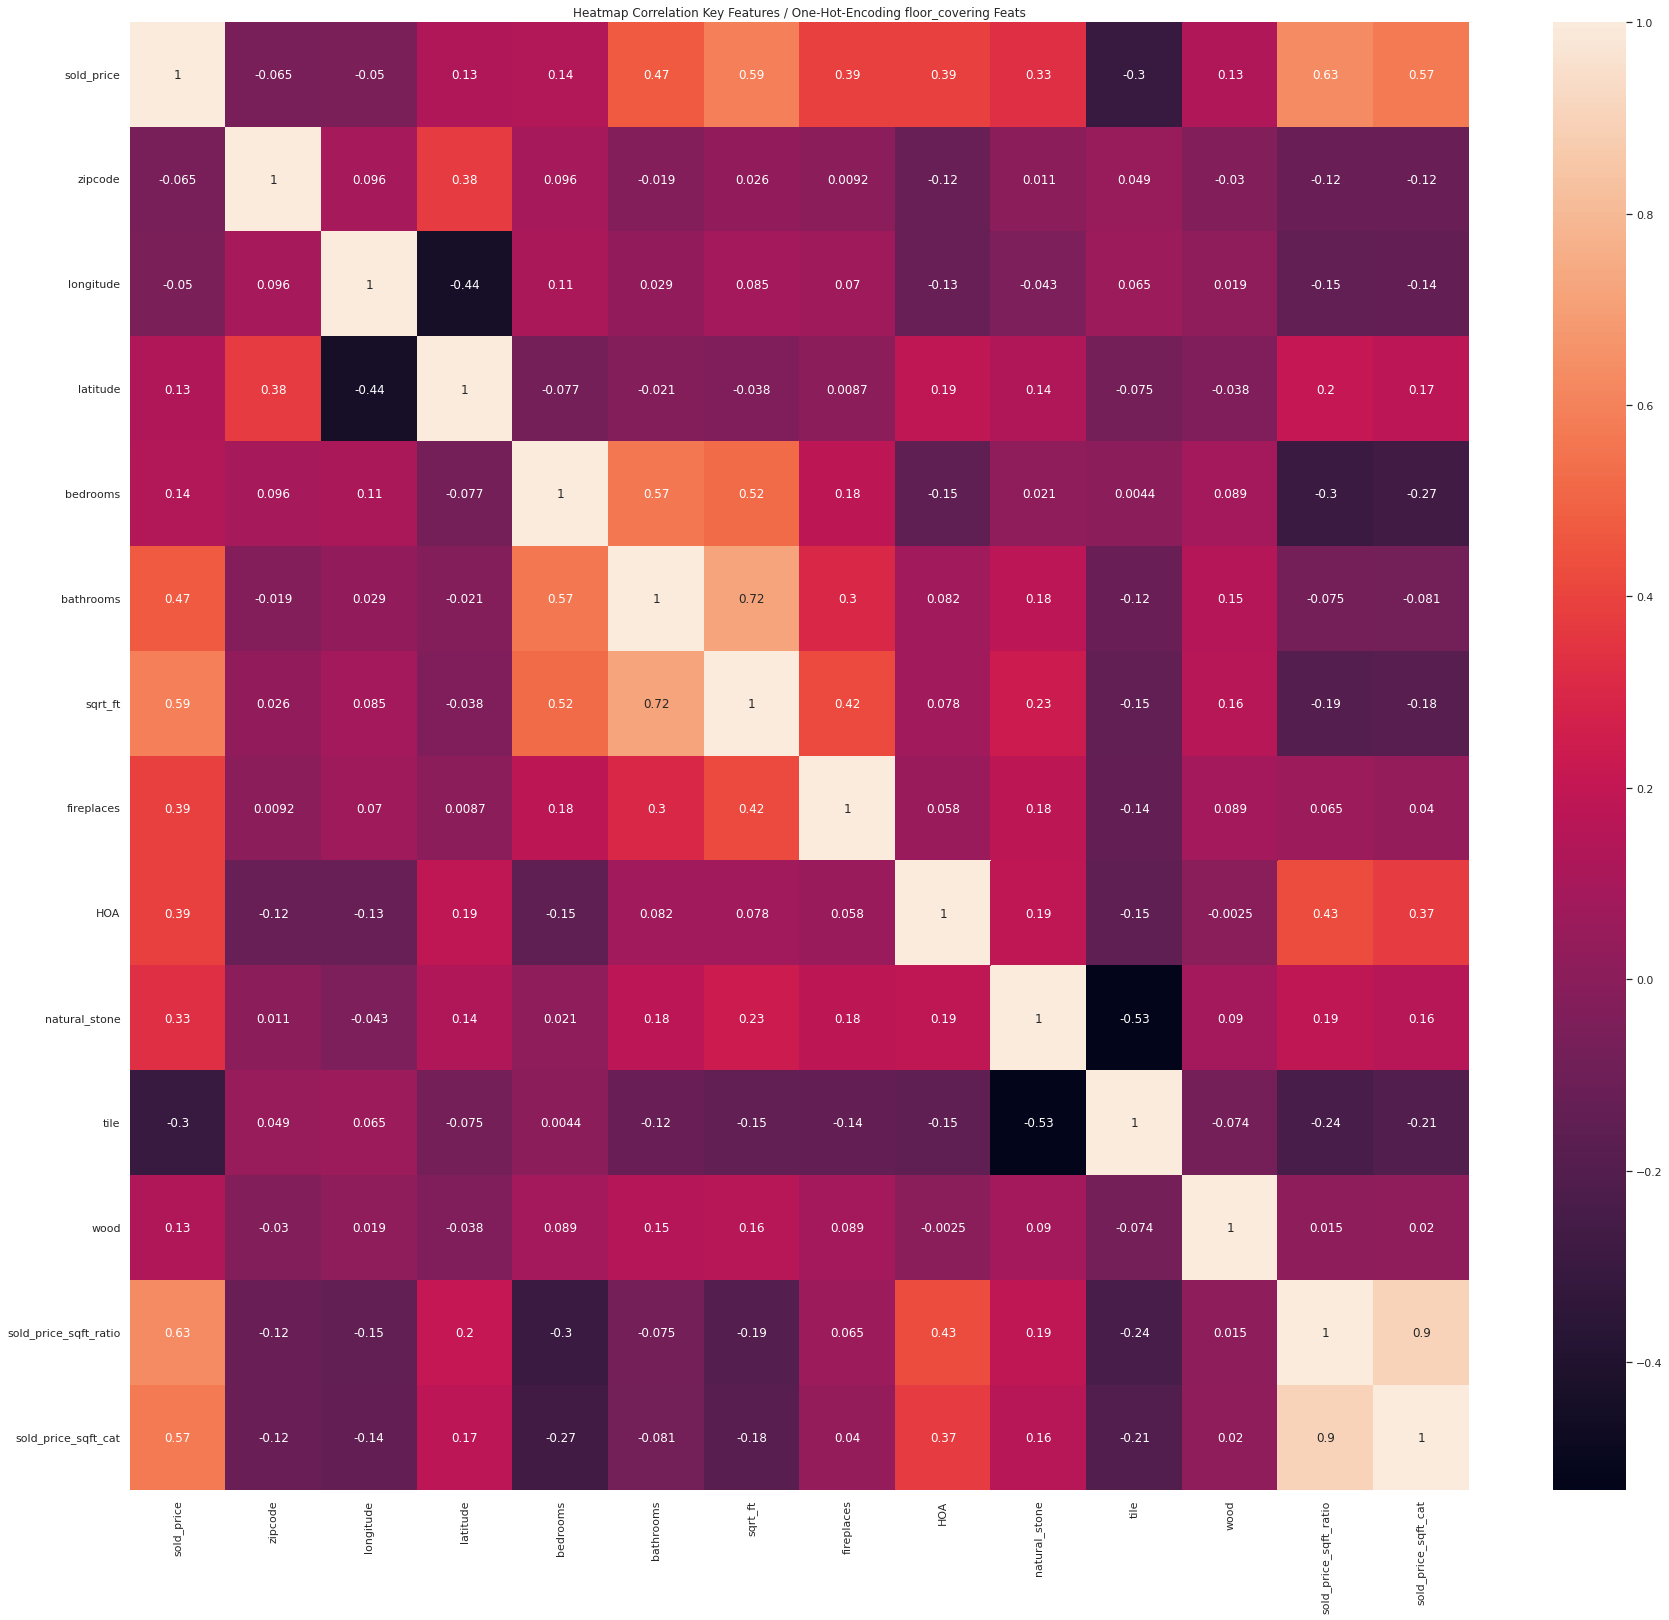

In [35]:
# Correlation on floor_covering One-Hot-Encoding features
correlation = X_train.corr()
plt.figure(figsize=(30,27))
sn.heatmap(correlation, xticklabels=correlation.columns, yticklabels=correlation.columns, annot=True)
plt.title('Heatmap Correlation Key Features / One-Hot-Encoding floor_covering Feats')
plt.savefig('figure5_original_heatmap_correlations_key_features_floor_covering_ohe.png')

## 11) Regression Models (KNN, LR, MLR, OLS Gradient Descent)

In [36]:
# NOTE: Supervised Learning Algorithm (Regression) -Bayes Theorem (Cov Matrix) (inputs as numpy.array)

class KNNRegressor():
  
  def fit(self, X, y):
    self.X = X
    self.y = y

  def predict(self, X, K, epsilon=1e-3):
    N = len(X)
    y_hat = np.zeros(N)

    for i in range(N):
      dist2 = np.sum((self.X-X[i])**2, axis=1)
      idxt = np.argsort(dist2)[:K]
      gamma_k = np.exp(-dist2[idxt])/np.exp(-dist2[idxt]).sum()
      y_hat[i] = gamma_k.dot(self.y[idxt])
      
    return y_hat


class SimpleLinearRegression():

  def fit(self, X, y):
    self.y = y
    self.d = np.mean(X**2) - np.mean(X)**2
    self.w0 = ((np.mean(y)*np.mean(X**2))-(np.mean(X)*np.mean(X*y)))/self.d
    self.w1 = (np.mean(X*y)-(np.mean(X)*np.mean(y)))/self.d
    
  def predict(self, X, show=False):
    y_hat = self.w0 + self.w1*X
    if show:
      plt.figure()
      plt.scatter(X, self.y, s=8)
      plt.plot(X, y_hat, color="#FF0070")
    return y_hat

class MultivariateLinearRegression():

  def fit(self, X, y):
    self.w = np.linalg.solve(X.T@X, X.T@y) #Solving the Equations from w = X.T*y/X.T*X

  def predict(self, X):
    return np.matmul(X, self.w)


class OutLinearRegression():

  def fit(self, X, Y, eta=1e-3, epochs=1e3, show_curve=False):
    epochs = int(epochs)
    N, D = X.shape

    # Initialize Weights
    self.W = np.random.randn(D)

    # Initialize Loss Function
    J = np.zeros(epochs)

    # Gradient Descent
    for epoch in range(epochs):
      Y_hat = self.predict(X)
      J[epoch] = OLS(Y, Y_hat, N)
      self.W -= eta*(1/N)*(X.T@(Y_hat-Y))

    if show_curve:
      plt.figure()
      plt.plot(J)
      plt.xlabel("epochs")
      plt.ylabel("$\mathcal{J}")
      plt.title("Training Curve")

  def predict(self, X):
    return X@self.W

In [37]:
# KPI - Regression Key Performance Indicators

# 1) Mean Squared Error
def mse(y, y_hat):
  return np.sum((y-y_hat)**2)/(y.shape[0])
# 2) Variance (Mean)
def variance_mean_y(y, y_hat):
  return np.sum((y-np.mean(y))**2)/(y.shape[0])
# 3) Variance (Median)
def variance_med_y(y, y_hat):
  return np.sum((y-np.median(y))**2)/(y.shape[0])
# 4) 1-R2 
def R2(Y, Y_hat):
  return 1.0 - (np.sum((Y-Y_hat)**2) / np.sum((Y-np.mean(Y))**2))
# 5) Ordinary Least Squares
def OLS(Y, Y_hat, N):
  return (1/(2*N))*np.sum((Y-Y_hat)**2)

## 12) Model Training for sold_price forecasting 

In [38]:
# KNN/Multivariate Linear Regression (sold_price forecasting)
X_train_ = X_train.loc[:, X_train.columns != 'sold_price'].copy(deep=True)
y_train_ = X_train['sold_price'].copy(deep=True)
X_test_ = X_test.loc[:, X_train.columns != 'sold_price'].copy(deep=True)
y_test_ = X_test['sold_price'].copy(deep=True)

knnr = KNNRegressor()
knnr.fit(X_train_.to_numpy(), y_train_.to_numpy())
y_tr_hat_knn = knnr.predict(X_train_.to_numpy(), 3)
mse_y_knn = mse(y_train_.to_numpy(), y_tr_hat_knn)
var_med_y = variance_med_y(y_train_.to_numpy(), y_tr_hat_knn)
var_mean_y = variance_mean_y(y_train_.to_numpy(), y_tr_hat_knn)
r2_y = R2(y_train_, y_tr_hat_knn)


print("KNN Variance of Y (Median): "+str(var_med_y))
print("KNN Variance of Y (Mean): "+str(var_mean_y))
print("KNN MSE of Y: "+str(mse_y_knn))
print("KNN R2 of Y: "+str(r2_y))

#np.argwhere(np.isnan(x))


KNN Variance of Y (Median): 95499758174.58812
KNN Variance of Y (Mean): 86501367035.70815
KNN MSE of Y: 1619.4506657791562
KNN R2 of Y: 0.9999999812783229


In [39]:
mlr = MultivariateLinearRegression()
mlr.fit(X_train_.to_numpy(), y_train_.to_numpy())
y_tr_hat_mlr = mlr.predict(X_train_.to_numpy())
mse_y = mse(y_train_.to_numpy(), y_tr_hat_mlr)
var_med_y = variance_med_y(y_train_.to_numpy(), y_tr_hat_mlr)
var_mean_y = variance_mean_y(y_train_.to_numpy(), y_tr_hat_mlr)
r2_y = R2(y_train_.to_numpy(), y_tr_hat_mlr)


print("KNN Variance of Y (Median): "+str(var_med_y))
print("KNN Variance of Y (Mean): "+str(var_mean_y))
print("KNN MSE of Y: "+str(mse_y))
print("KNN R2 of Y: "+str(r2_y))

KNN Variance of Y (Median): 95499758174.58812
KNN Variance of Y (Mean): 86501367035.70815
KNN MSE of Y: 6264268674.587561
KNN R2 of Y: 0.9275818534520773


In [40]:
print(y_test_)
y_ts_hat_mlr = mlr.predict(X_test_.to_numpy())
mse_y = mse(y_test_.to_numpy(), y_ts_hat_mlr)
var_med_y = variance_med_y(y_test_.to_numpy(), y_ts_hat_mlr)
var_mean_y = variance_mean_y(y_test_.to_numpy(), y_ts_hat_mlr)
r2_y = R2(y_test_.to_numpy(), y_ts_hat_mlr)


print("KNN Variance of Y (Median): "+str(var_med_y))
print("KNN Variance of Y (Mean): "+str(var_mean_y))
print("KNN MSE of Y: "+str(mse_y))
print("KNN R2 of Y: "+str(r2_y))

4226     870000.0
4227     740000.0
4228     740000.0
4229     660000.0
4230     990000.0
          ...    
4690     815000.0
4691     805635.0
4692    1100000.0
4693     542000.0
4694    1260000.0
Name: sold_price, Length: 469, dtype: float64
KNN Variance of Y (Median): 99036866806.49933
KNN Variance of Y (Mean): 90525160131.46286
KNN MSE of Y: 4458894234.952254
KNN R2 of Y: 0.9507441441862468


In [41]:
y_ts_hat_knn = knnr.predict(X_test_.to_numpy(), 10)
mse_y_knn = mse(y_test_.to_numpy(), y_ts_hat_knn)
var_med_y = variance_med_y(y_test_.to_numpy(), y_ts_hat_knn)
var_mean_y = variance_mean_y(y_test_.to_numpy(), y_ts_hat_knn)
r2_y = R2(y_test_.to_numpy(), y_ts_hat_knn)
print("KNN Variance of Y (Median): "+str(var_med_y))
print("KNN Variance of Y (Mean): "+str(var_mean_y))
print("KNN MSE of Y: "+str(mse_y_knn))
print("KNN R2 of Y: "+str(r2_y))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in true_divide
  app.launch_new_instance()


KNN Variance of Y (Median): 99036866806.49933
KNN Variance of Y (Mean): 90525160131.46286
KNN MSE of Y: nan
KNN R2 of Y: nan


## 13) Model Training for house material prediction (natural_stone, wood, tile)

In [42]:
from geopy import Nominatim

geolocator = Nominatim(user_agent='Silly_Pandas')

# Locating by latitude, longitude
#location = geolocator.reverse("31.46, -110.24")
#location.raw

loc = geolocator.geocode('3109 South Woodruff Mesa AZ')
#loc.point
data = loc.raw
loc_data = data['display_name'].split()
print(loc_data)
print(loc_data[-3])




['3109,', 'South', 'Woodruff,', 'Boulder', 'Creek,', 'Mesa,', 'Maricopa', 'County,', 'Arizona,', '85212,', 'United', 'States']
85212,
